In [277]:
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder
import category_encoders as ce


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gc
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold


import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
sample_submit = pd.read_csv('../input/sample_submit.csv', header=None, names=['id', 'y'])
print('train :', len(train_df))
print('test: ', len(test_df))
print('sample_submit :', len(sample_submit))

train : 55583
test:  18528
sample_submit : 18528


In [278]:
class GroupFeatureExtractor:
    EX_TRANS_METHODS = ['deviation', 'zscore', 'count', 'mean', 'sum', 'std']
    
    def __init__(self, group_key, group_values, agg_methods):
        self.group_key = group_key
        self.group_values = group_values
        
        self.ex_trans_methods = [m for m in agg_methods if m in self.EX_TRANS_METHODS]
        self.agg_methods = [m for m in agg_methods if m not in self.ex_trans_methods]
        self.df_agg = None

    def fit(self, df, y=None):
        if not self.agg_methods:
            return
        dfs = []
        for agg_method in self.agg_methods:
            if callable(agg_methods): # 呼び出し可能か判定
                agg_method_name = agg_method.__name__ # ?
            else:
                agg_method_name = agg_method
            df_agg = (df[[self.group_key] + self.group_values].groupby(self.group_key).agg(agg_method))
            df_agg.columns = self._get_columns_names(agg_method_name)
            dfs.append(df_agg)
        self.df_agg = pd.concat(dfs, axis=1).reset_index()
        
    def transform(self, df_eval):
        key = self.group_key
        if self.agg_methods:
            df_features = pd.merge(df_eval[[self.group_key]], self.df_agg, on=self.group_key, how='left')
        else:
            df_features = df_eval[[self.group_key]].copy()
        if self.ex_trans_methods:
            if 'deviation' in self.ex_trans_methods:
                df_features[self._get_column_names('deviation')] = df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform('mean')
            if 'zscore' in self.ex_trans_methods:
                df_features[self._get_column_names('zscore')] = (df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform('mean')) \
                                                                                                            / (df_eval[[key]+self.group_values].groupby(key).transform('std') + 1e-8)
            if 'count' in self.ex_trans_methods:
                df_features[self._get_column_names('count')] = df_eval[[key]+self.group_values].groupby(key).transform('count')

            if 'sum' in self.ex_trans_methods:
                df_features[self._get_column_names('sum')] = df_eval[[key]+self.group_values].groupby(key).transform('sum')

            if 'mean' in self.ex_trans_methods:
                df_features[self._get_column_names('mean')] = df_eval[[key]+self.group_values].groupby(key).transform('mean')

            if 'std' in self.ex_trans_methods:
                df_features[self._get_column_names('std')] = df_eval[[key]+self.group_values].groupby(key).transform('std')

            df_features.drop(self.group_key, axis=1, inplace = True)
            return df_features
        
    def _get_column_names(self, method):
        return [f'agg_{method}_{col}_grpby_{self.group_key}' for col in self.group_values]
        
    def fit_transform(self, df, y=None):
        self.fit(df, y=y)
        return self.transform(df)

In [329]:
class KNNFeatureExtractor:
    def __init__(self, n_neighbors=5):
        self.knn = KNeighborsClassifier(n_neighbors + 1)
    def fit(self, X, y):
        self.knn.fit(X, y)
        self.y = y if isinstance(y, np.ndarray) else np.array(y)
        return self
    def transform(self, X, is_train_data):
        distances, indexes = self.knn.kneighbors(X)
        distances = distances[:, 1:] if is_train_data else distances[:, :-1]
        indexes = indexes[:, 1:] if is_train_data else indexes[:, :-1]
        labels = self.y[indexes]
        score_columns = [f"knn_score_class{c:02d}" for c in range(N_CLASSES)]
        # score_columns = [f"knn_score_class{c:02d}" for c in range(0,5)]
        df_knn = pd.DataFrame(
            [np.bincount(labels_, distances_, N_CLASSES) for labels_, distances_ in zip(labels, 1.0 / distances)],
            columns=score_columns
        )
        # 最大スコア
        df_knn.loc[:, 'max_knn_scores'] = df_knn.max(axis=1)

        # 最大スコアとの差。0は最大スコアを表す
        for col in score_columns:
            df_knn.loc[:, f'sub_max_knn_scores_{col}'] = df_knn['max_knn_scores'] - df_knn[col]

        # 最大スコアとの比。1は最大スコアを表す
        for col in score_columns:
            df_knn.loc[:, f'div_max_knn_scores_{col}'] = df_knn[col] / df_knn['max_knn_scores']

        # それぞれのスコア同士の差
        for i, col1 in enumerate(score_columns):
            for j, col2 in enumerate(score_columns[i+1:], i+1): # 全パターンを網羅できる
                df_knn.loc[:, f'sub_{col1}_{col2}'] = df_knn[col1] - df_knn[col2]

        # knnスコアの合計
        df_knn.loc[:, 'sum_knn_scores'] = df_knn.sum(axis=1)

        return df_knn


# preprocess

In [280]:
train = train_df.copy()
test = test_df.copy()
target = train.pop('y')
all_df = pd.concat([train, test], axis=0)
all_df = all_df.drop(['id'], axis=1)
all_df = all_df.reset_index(drop=True)

# all_df = all_df.fillna('nan')
# categorical columns
cat_col = ['bed_type', 'cancellation_policy', 'city',
            'cleaning_fee', 'host_has_profile_pic',
            'host_identity_verified', 'instant_bookable',
            'name', 'neighbourhood', 'property_type', 'room_type',
            'thumbnail_url']
le = LabelEncoder()
for col in cat_col:
    all_df[col] = le.fit_transform(all_df[col])
for col in cat_col:
    train[col] = le.fit_transform(train[col])
for col in cat_col:
    test[col] = le.fit_transform(test[col])
# ce = ce.CountEncoder()
# for col in cat_col:
#     all_df[f'ce_{col}'] = ce.fit_transform(all_df[col])

te = TargetEncoder(smoothing=0.1)
for col in cat_col:
    train[f'te_{col}'] = te.fit_transform(train[col], target)
for col in cat_col:
    test[f'te_{col}'] = te.transform(test[col])

# date to one-hot
def convert_date(df_, col):
    df = df_.copy()
    df[col] = pd.to_datetime(df[col])
    df[f'{col}_year'] = df[col].map(lambda x: x.year)
    df[f'{col}_month'] = df[col].map(lambda x: x.month)
    df[f'{col}_day'] = df[col].map(lambda x: x.day)
    df = df.drop(col, axis=1)
    return df
all_df = convert_date(all_df, 'first_review')
all_df = convert_date(all_df, 'host_since')
all_df = convert_date(all_df, 'last_review')


# description
# length of sentence
all_df['n_description'] = all_df['description'].apply(lambda x: len(x))
all_df = all_df.drop('description', axis=1)


# address
def processing_address(x):
    if type(x)!=float:
        x = x.strip('-')
    return x
all_df['zipcode'].apply(processing_address)
le = LabelEncoder()
all_df['zipcode'] = le.fit_transform(all_df['zipcode'])


# host_response_rate
# 100% → 100
def processing_rate(x):
    if x==object:
        x.strip('%')
    return x
all_df['host_response_rate'] = all_df['host_response_rate'].map(processing_rate)
le = LabelEncoder()
all_df['host_response_rate'] = le.fit_transform(all_df['host_response_rate'])


# amenities
# dict → one-hot
def processing_amenities(x):
    x = x.replace('{','')
    x = x.replace('}','')
    x = x.replace('"','')
    x = x.split(',')
    return x
all_df['amenities'] = all_df['amenities'].apply(processing_amenities)
mlb = MultiLabelBinarizer(sparse_output=True)
all_df = all_df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(all_df.pop('amenities')),
                index=all_df.index,
                columns=mlb.classes_))


# others
obj_col = all_df.select_dtypes(include=object)
le = LabelEncoder()
for col in obj_col.columns:
    all_df[col] = le.fit_transform(all_df[col])

all_df = all_df.fillna(-9999)
all_df = all_df.rename(columns={'translation missing: en.hosting_amenity_49':'unknown_49'})
all_df = all_df.rename(columns={'translation missing: en.hosting_amenity_50':'unknown_50'})

gc.collect()

sc_col = [
            'accommodates',
            'bathrooms',
            # 'bed_type',
            'bedrooms',
            # 'beds',
            # 'cancellation_policy',
            'city',
            # 'cleaning_fee',
            # 'host_has_profile_pic',	
            # 'host_identity_verified',
            'host_response_rate',
            # 'instant_bookable',
            'latitude',
            'longitude',
            # 'name',
            # 'neighbourhood',
            'number_of_reviews',
            'property_type',
            'review_scores_rating',
            'room_type',
            'thumbnail_url',
            'zipcode',
            # 'first_review_year',
            # 'first_review_month',
            # 'first_review_day',
            # 'host_since_year',
            # 'host_since_month',
            #  'host_since_day',
            # 'last_review_year',
            # 'last_review_month',
            # 'last_review_day',
            # 'n_description'
            ]
# standard scale
X = all_df[sc_col]
sc = StandardScaler()
X_norm = sc.fit_transform(X)
clf = KMeans(n_clusters=7)
kmeans_score =clf.fit_predict(X_norm)
all_df['kmeans_score'] = kmeans_score

# aggregated features
group_key = 'city'
group_values = ['accommodates',
                'bathrooms',
                'bed_type',
                'bedrooms',
                'beds',
                'cancellation_policy',
                # 'city',
                'cleaning_fee',
                'host_has_profile_pic',
                'host_identity_verified',
                'host_response_rate',
                'instant_bookable',
                'latitude',
                'longitude',
                'name',
                'neighbourhood',
                'number_of_reviews',
                'property_type',
                'review_scores_rating',
                'room_type',
                'thumbnail_url',
                'zipcode']
agg_methods = [
                'deviation',
                 'zscore',
                 'std',
                #  'mean',
                #  'count',
                #  'sum',
                #  'median'
                 ]
gfe = GroupFeatureExtractor(
    group_key=group_key,
    group_values=group_values,
    agg_methods=agg_methods)
df_ = gfe.fit_transform(all_df)
all_df = pd.concat([all_df, df_], axis=1)
all_df = all_df.drop('kmeans_score', axis=1)

# standard scaling
def make_sc_df(df, sc_features_name=sc_features_name):
    sc = StandardScaler()
    dfs = []
    for col in sc_features_name:
        df_tmp = pd.DataFrame()
        df_tmp[f'Standardscaled_{col}'] = sc.fit_transform(df[[col]])[:, 0]
        dfs.append(df_tmp)
    dfs = pd.concat(dfs, axis=1)
    return dfs

train_ = all_df[:55583]
test_ = all_df[55583:]
print('train:',train_.shape)
print('test:',test_.shape)

/Users/shugo/Desktop/Competitions/SIGNATE/AIQuest2021/venv_AIQuest2021/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
ipykernel_launcher:142: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train: (55583, 226)
test: (18528, 226)


<AxesSubplot:xlabel='y', ylabel='Count'>

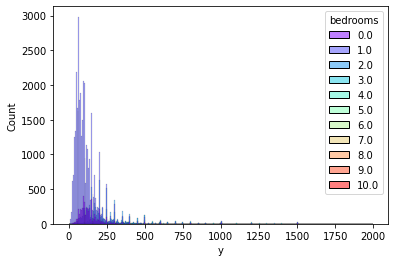

In [310]:
sns.histplot(data=train_df, x='y', hue='bedrooms', palette='rainbow')

In [314]:
train_df[['bedrooms', 'bathrooms', 'y']].corr()

,bedrooms,bathrooms,y
bedrooms,1.000000,0.586366,0.495830
bathrooms,0.586366,1.000000,0.456044
y,0.495830,0.456044,1.000000


# train

In [337]:
train = train_.copy()
test = test_.copy()
n_splits = 5
N_CLASSES = 12
kf = KFold(n_splits=n_splits, shuffle=True, random_state=71)
X = train
y = target.copy()
# target_knn = pd.cut(target, bins=7, labels=False)
target_knn = train['bedrooms']
models = []
scores = []
preds = np.zeros((len(test),5))
for i, (train_index, valid_index) in enumerate(kf.split(X, y)):

    test = test_.copy()
    X_train = X.loc[train_index].reset_index(drop=True)
    y_train = y.loc[train_index].reset_index(drop=True)
    X_valid = X.loc[valid_index].reset_index(drop=True)
    y_valid = y.loc[valid_index].reset_index(drop=True)
    y_knn_train = target_knn.loc[train_index].reset_index(drop=True)
    y_knn_valid = target_knn.loc[valid_index].reset_index(drop=True)

    # extract knn feature
    sc_features_name = ['accommodates', 
                        'bathrooms', 'bed_type', 'beds',
       'cancellation_policy', 'city', 'cleaning_fee',
       'host_identity_verified', 'instant_bookable',
       'latitude', 'longitude', 'neighbourhood', 'number_of_reviews',
       'property_type', 'room_type', 'thumbnail_url',
       'zipcode']
    # sc_features_name = [
    #     # 'bedrooms', 
    #     'bathrooms', 'agg_zscore_accommodates_grpby_city',
    #    'room_type', 'agg_deviation_accommodates_grpby_city', 'longitude', 'zipcode',
    #    'agg_deviation_zipcode_grpby_city', 'last_review_year',
    #    'agg_deviation_longitude_grpby_city', 'agg_std_latitude_grpby_city',
    #    'agg_deviation_latitude_grpby_city',
    #    'agg_zscore_latitude_grpby_city', 'n_description',
    #    'agg_zscore_longitude_grpby_city']

    # drop nan
    X_train_knn = X_train[X_train['bedrooms']!=-9999].reset_index(drop=True).astype(int)
    X_valid_knn = X_valid[X_valid['bedrooms']!=-9999].reset_index(drop=True).astype(int)
    test_knn = test[test['bedrooms']!=-9999].reset_index(drop=True).astype(int)
    y_knn_train = y_knn_train.loc[y_knn_train!=-9999].reset_index(drop=True).astype(int)

    X_train_knn = X_train_knn.drop('bedrooms', axis=1)
    X_valid_knn = X_valid_knn.drop('bedrooms', axis=1)
    test_knn = test_knn.drop('bedrooms', axis=1)

    X_train_knn = make_sc_df(X_train_knn.fillna(0.0), sc_features_name=sc_features_name)
    X_valid_knn = make_sc_df(X_valid_knn.fillna(0.0), sc_features_name=sc_features_name)
    test_knn = make_sc_df(test_knn.fillna(0.0), sc_features_name=sc_features_name)

    knn_feature_extractor = KNNFeatureExtractor(5).fit(X_train_knn, y_knn_train)
    X_train = pd.concat([X_train, knn_feature_extractor.transform(X_train_knn, is_train_data=True)], axis=1)
    X_valid = pd.concat([X_valid, knn_feature_extractor.transform(X_valid_knn, is_train_data=False)], axis=1)
    test_knn_features = knn_feature_extractor.transform(test_knn, is_train_data=False)

    for col in test_knn_features.columns:
        test[col] = test_knn_features[col]

    # drop class05-class11
    def drop_class(df):
        for col in df:
            for i in range(5,12):
                if (f'class0{i}' in col) or ('class{i}' in col):
                    if col in df.columns:
                        df = df.drop(col, axis=1)
        return df
    X_train = drop_class(X_train)
    X_valid = drop_class(X_valid)
    test = drop_class(test)

    # lgb
    lgb_train = lgb.Dataset(X_train.values, y_train)
    lgb_valid = lgb.Dataset(X_valid.values, y_valid)

    params ={'objective':'regression',
            'seed':71,
            'verbose':-1,
            'metrics':'rmse'}
    model = lgb.train(params, lgb_train, verbose_eval=False, early_stopping_rounds=100, num_boost_round=9999,
                        valid_names=['train','test'], valid_sets=[lgb_train, lgb_valid])
    valid_pred = model.predict(X_valid)

    score = mean_squared_error(y_valid, valid_pred, squared=False)
    # test pred
    test_pred = model.predict(test)

    models.append(model)
    scores.append(score)
    preds[:,i] = test_pred
    print(f'Fold{i}:', score)

print('cv:', np.mean(scores))

ipykernel_launcher:16: RuntimeWarning: divide by zero encountered in true_divide
ipykernel_launcher:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Fold0: 104.04944465972612


ipykernel_launcher:16: RuntimeWarning: divide by zero encountered in true_divide
ipykernel_launcher:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Fold1: 100.40000484882574


ipykernel_launcher:16: RuntimeWarning: divide by zero encountered in true_divide
ipykernel_launcher:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Fold2: 101.83911269348569


ipykernel_launcher:16: RuntimeWarning: divide by zero encountered in true_divide
ipykernel_launcher:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Fold3: 103.90972580175115


ipykernel_launcher:16: RuntimeWarning: divide by zero encountered in true_divide
ipykernel_launcher:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Fold4: 111.27412396652696
cv: 104.29448239406312


In [336]:
X_train['sub_knn_score_class05_knn_score_class06']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
44461    NaN
44462    NaN
44463    NaN
44464    NaN
44465    NaN
Name: sub_knn_score_class05_knn_score_class06, Length: 44466, dtype: float64

In [320]:
def visualize_importance():
    feature_importance_df = pd.DataFrame()

    for i,model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = X_train.columns
        _df['fold'] = i+1
        feature_importance_df = pd.concat([feature_importance_df,_df],axis=0,ignore_index=True)
    
    order = feature_importance_df.groupby('column').sum()[['feature_importance']].sort_values('feature_importance',ascending=False).index[:50]

    fig, ax = plt.subplots(1,1,figsize=(max(6, len(order) * .4), 8))
    sns.boxenplot(data=feature_importance_df, x='feature_importance', y='column', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x')
    ax.grid()
    fig.tight_layout()
    return fig,ax

def get_top_importance(models, n):
    feature_importance_df = pd.DataFrame()
    for i,model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = X_train.columns
        _df['fold'] = i+1
        feature_importance_df = pd.concat([feature_importance_df,_df],axis=0,ignore_index=True)
    
    order = feature_importance_df.groupby('column').sum()[['feature_importance']].sort_values('feature_importance',ascending=False).iloc[:n,:]#.index[:n]
    return order

(<Figure size 1440x576 with 1 Axes>,
 <AxesSubplot:xlabel='feature_importance', ylabel='column'>)

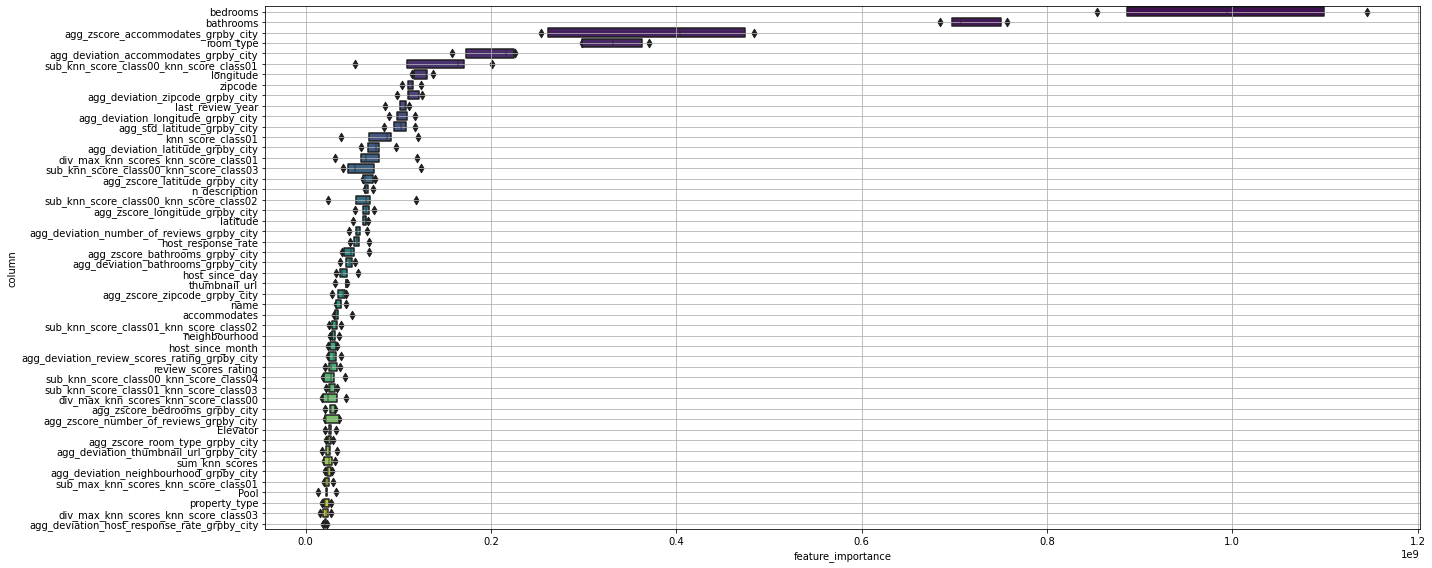

In [204]:
visualize_importance()

In [321]:
imp = get_top_importance(models, 250)

In [316]:
imp

Index(['bedrooms', 'bathrooms', 'agg_zscore_accommodates_grpby_city',
       'room_type', 'agg_deviation_accommodates_grpby_city',
       'last_review_year', 'agg_std_latitude_grpby_city', 'longitude',
       'zipcode', 'agg_deviation_zipcode_grpby_city',
       'agg_deviation_longitude_grpby_city',
       'agg_deviation_number_of_reviews_grpby_city',
       'agg_deviation_latitude_grpby_city', 'latitude', 'host_response_rate',
       'agg_zscore_longitude_grpby_city', 'agg_zscore_latitude_grpby_city',
       'review_scores_rating', 'n_description',
       'agg_deviation_bathrooms_grpby_city'],
      dtype='object', name='column')

In [325]:
pd.options.display.max_rows = 150
imp.iloc[150:, :]

,feature_importance
column,
sub_knn_score_class01_knn_score_class05,3.074157e+06
agg_std_thumbnail_url_grpby_city,2.918919e+06
sub_knn_score_class05_knn_score_class06,2.763112e+06
sub_knn_score_class02_knn_score_class05,2.645704e+06
agg_std_number_of_reviews_grpby_city,2.506355e+06
sub_knn_score_class02_knn_score_class06,2.414738e+06
Bathtub,2.203925e+06
sub_max_knn_scores_knn_score_class07,2.122044e+06
Smoking allowed,2.110099e+06


# submission

In [101]:
y_preds = []
for i in range(len(preds)):
    y_pred = np.mean(preds[i])
    y_preds.append(y_pred)
y_preds = pd.Series(y_preds)
sample_submit['y'] = y_preds
sample_submit.to_csv('../output/sub_nb001.csv', index=False, header=False)